# List all the PRU-15 MPs

In [1]:
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# get the data
# define the browser
chrome_opts = Options()
chrome_opts.add_argument("--disable-notifications")
driver = webdriver.Chrome(service=Service("chromedriver.exe"),options=chrome_opts)
# open the browser and go to the page
driver.get("https://www.bharian.com.my/berita/nasional/2022/11/1028360/keputusan-rasmi-pru15")
# get the section of website with the information
content = WebDriverWait(driver,20).until(
    EC.presence_of_element_located((By.CLASS_NAME,'dable-content-wrapper')))
text = content.text
# close the browser
driver.close()

In [2]:
import re
import pandas as pd
# split the content into lines
lines = [l for l in text.split('\n')]
# only extract all winners (there are many different patterns)
patt = "^P*\d+\:* .+" # pattern to get the parliment number and names
# except P17 PADANG SERAI because not contested
parliments = [(i,x) for i,x in enumerate(lines)
                if re.match(patt,x)
                and "P17 PADANG SERAI" not in x]
# sepecific because no 'MENANG' mentioned in line
# selayang and bandar tun razak wrong winners stated in the articles 
special = [(i,x) for i,x in enumerate(lines)
        if '1. DATUK ANYI NGAU (GPS-PDP)' in x or # baram
        '2. DATUK SERI AZALINA OTHMAN SAID (BN-UMNO)' in x or # pengerang
        '1.  Wan Azizah Wan Ismail (PH-PKR)' in x or # bandar tun razak
        '5. William Leong (PH-PKR)' in x] # selayang
# contains menang except bandar tun razak and selayang
members = [(i,x) for i,x in enumerate(lines)
            if "menang" in x.lower() and
            '2. KAMARUDIN JAFFAR (PN-BERSATU)' not in x and # bandar tun razak
            '1.  ABDUL RASHID ASARI (PN-BERSATU)' not in x] # selayang
# keep data into dataframes
ps = pd.DataFrame(parliments,columns=['line','item'])
sp = pd.DataFrame(special,columns=['line','item'])
ms = pd.DataFrame(members,columns=['line','item'])
# check the data content
len(ps),len(ms),len(sp)

(221, 217, 4)

In [3]:
# put all the result back into one dataframe
sorted_results = pd.concat([ps,ms,sp]).sort_values('line').reset_index(drop=True)
# index odd is parliment and index even is winner
plms = sorted_results[sorted_results.index%2 == 0].reset_index(drop=True)
mems = sorted_results[sorted_results.index%2 == 1].reset_index(drop=True)
results = plms.join(mems,lsuffix='_').drop(['line_','line'],axis=1)
results.columns = ['p','m']
results.head()

,p,m
0,P1 PADANG BESAR,"3. RUSHDAN RUSMI (PN-PAS) 24,267 MENANG"
1,P2 KANGAR,"1. ZAKRI HASSAN (PN-BERSATU) 24,562 MENANG"
2,P3 ARAU,"2. SHAHIDAN KASSIM (PN- BERSATU) 31,458 MENANG"
3,P4 LANGKAWI,"3. SUHAIMI ABDULLAH (PN-BERSATU) 25,463 MENANG"
4,P5 JERLUN,"1. ABD GHANI AHMAD (PN-PAS) 31,685 MENANG"


In [4]:
# extract parliment numbers and parliment names
pnum = results['p'].apply(lambda x: x.split(" ",1)[0])
pname = results['p'].apply(lambda x: x.split(" ",1)[1])
# extract member's names, party, and their received votes
mname = results['m'].apply(lambda x: re.match('^\d*.(.+)\((.+)\)\s?(.+)',x).groups()[0])
mparty = results['m'].apply(lambda x: re.match('^\d*.(.+)\((.+)\)\s?(.+)',x).groups()[1])
mvotes = results['m'].apply(lambda x: re.match('^\d*.(.+)\((.+)\)\s?(.+)',x).groups()[2])
# clean the text votes and turn to integer
mvotes = (
    mvotes.str.replace('.','',regex=False)
    .str.replace(',','',regex=False)
    .str.replace('MENANG','',regex=False)
    .str.replace('menang','',regex=False)
    .str.replace('-','',regex=False)
    .str.replace(':','',regex=False)
    .str.replace(' ','',regex=False)
).astype('int')

In [5]:
# combine all the extracted data back into a dataframe
df = pd.concat([pnum,pname,mname,mparty,mvotes],axis=1)
df.columns = ['pnum','parliment','mp','party','votes']

In [6]:
# name the coalition
def coalition(party):
    for x in ['PN','BN','PH','GPS','GRS','BEBAS']:
        if x in party:
            return x
    for x in ['Warisan','WARISAN']:
        if x in party:
            return 'Warisan'
    for x in ['PAS','BERSATU']:
        if x in party:
            return 'PN'
    if 'DAP' in party:
        return 'PH'
    return 'OTHER'

df['coalition'] = df['party'].apply(coalition)
df.head()

,pnum,parliment,mp,party,votes,coalition
0,P1,PADANG BESAR,RUSHDAN RUSMI,PN-PAS,24267,PN
1,P2,KANGAR,ZAKRI HASSAN,PN-BERSATU,24562,PN
2,P3,ARAU,SHAHIDAN KASSIM,PN- BERSATU,31458,PN
3,P4,LANGKAWI,SUHAIMI ABDULLAH,PN-BERSATU,25463,PN
4,P5,JERLUN,ABD GHANI AHMAD,PN-PAS,31685,PN


# Visualisation

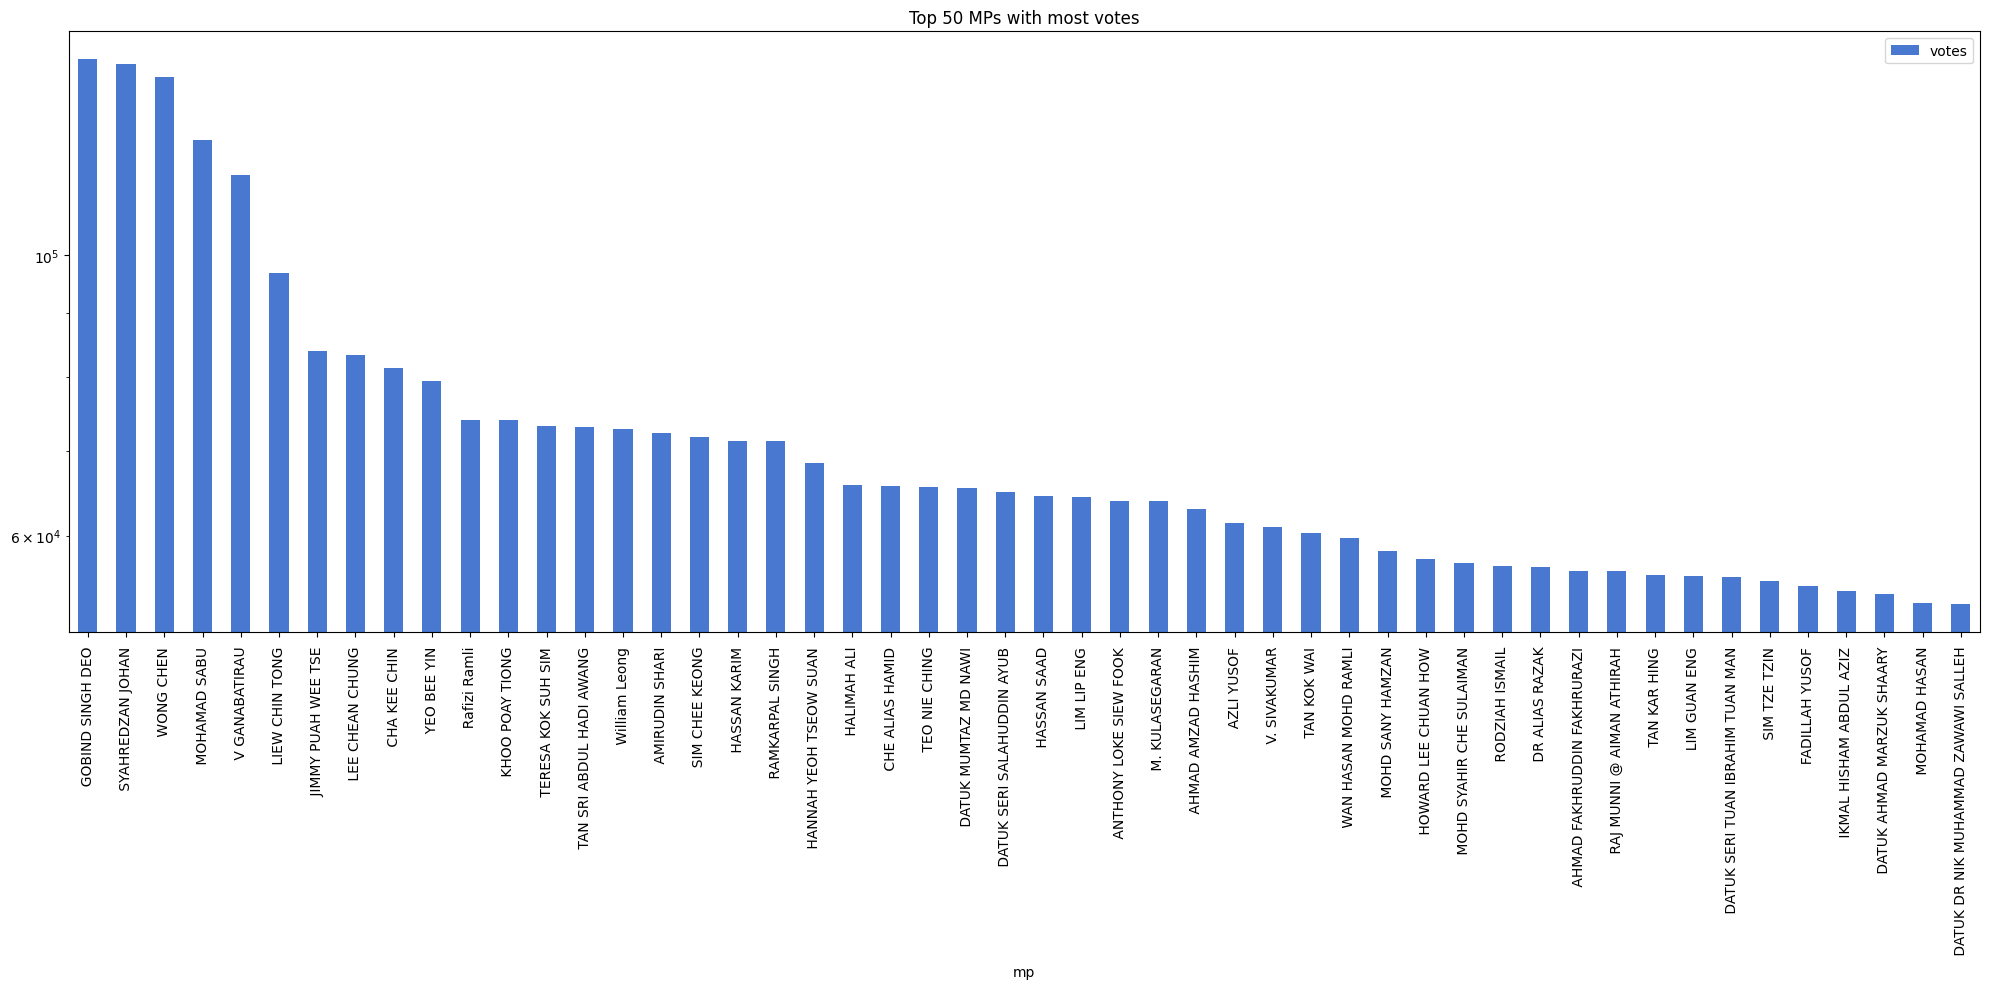

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')
# Top 50 members with most votes
df.sort_values('votes',ascending=False)[:50].plot(x='mp',kind='bar',figsize=(20,10))
plt.title('Top 50 MPs with most votes')
plt.yscale('log')
plt.tight_layout()
plt.show()

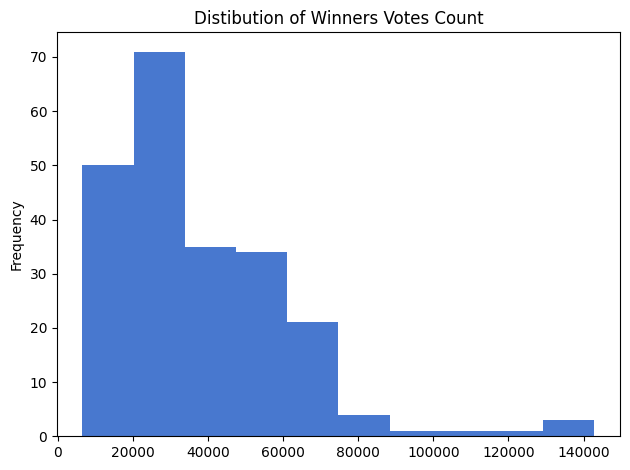

In [8]:
df.votes.plot(kind='hist')
plt.title('Distibution of Winners Votes Count')
plt.tight_layout()
plt.show()

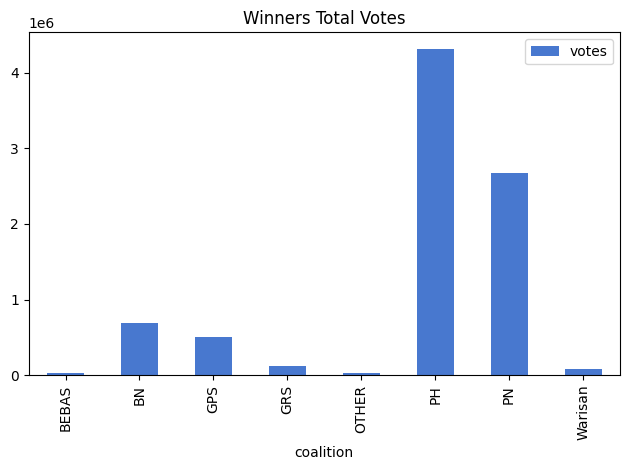

In [9]:
df[['votes','coalition']].groupby('coalition').sum().plot(kind='bar')
plt.title('Winners Total Votes')
plt.tight_layout()
plt.show()